In [20]:
import xgboost as xgb
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,ConfusionMatrixDisplay,classification_report
from scipy.stats import entropy
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier


In [2]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [3]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

In [4]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14_ CA53,X14_ CA54,X14_ CA55,X14_ CA58,X14_ CA59,X14_ CA60,X15_R1,X15_R2,X15_R3,Y
0,1.290226,2.112607,-0.522884,1.115542,-0.016684,2.512688,-0.497937,-0.005048,0.484781,1.378068,...,0,0,0,0,0,0,1,0,0,Toyota
1,0.380248,0.028934,-0.188861,2.250045,2.066725,0.924807,0.664973,0.888840,-0.010940,0.422940,...,0,0,0,0,0,0,1,0,0,BMW
2,-1.743034,-0.000464,0.590527,-0.120055,0.230500,-1.058322,0.831103,-1.111766,-1.229588,-0.635492,...,0,0,0,0,0,0,0,1,0,Honda
3,1.810213,-0.512413,-0.077520,0.312404,-0.316836,0.834421,0.930781,-0.090180,-0.713212,0.876429,...,0,0,0,0,1,0,1,0,0,GMC
4,0.706515,0.948202,-1.413614,-0.906344,-0.705268,2.775420,-0.165677,1.016538,0.815262,1.648586,...,0,0,0,0,0,0,1,0,0,Toyota


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,4250,object,6
X1,X1,4250,float64,1295
X2,X2,4250,float64,361
X3,X3,4250,float64,49
X4,X4,4250,float64,225
X5,X5,4250,float64,301
X6,X6,4250,float64,1675
X7,X7,4250,float64,164
X8,X8,4250,float64,132
X9,X9,4250,float64,241


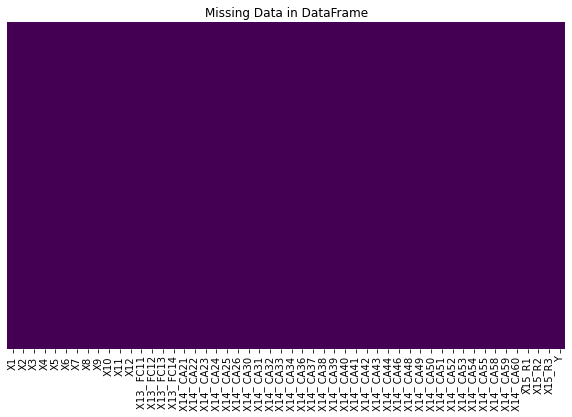

In [5]:

def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_data, sort_by='Column')


In [6]:
classes = train_data["Y"].unique()
number_of_classes = train_data["Y"].nunique()
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {number_of_classes}")
print(categorical_cols)

The classes is: ['Toyota' 'BMW' 'Honda' 'GMC' 'Mercedes' 'Ford']
Number of classes: 6
Index(['Y'], dtype='object')


In [7]:
X_train = train_data.drop('Y', axis=1).to_numpy()
y_train = pd.get_dummies(train_data['Y']).to_numpy()

X_val = val_data.drop('Y', axis=1).to_numpy()
y_val = pd.get_dummies(val_data['Y']).to_numpy()

X_test = test_data.drop('Y', axis=1).to_numpy()
y_test = pd.get_dummies(test_data['Y']).to_numpy()


# Building The Active Model with xgboost

In [21]:
X_train = np.vstack([X_train, X_val])
y_train = np.concatenate((y_train, y_val), axis = 0)

# Split the data into a pool (unlabeled) and an initial labeled set
X_pool, X_initial, y_pool, y_initial = train_test_split(
    X_train, y_train, train_size=100, stratify=y_train, random_state=777
)

# model = xgb.XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=777)
best_params= {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RF_model = RandomForestClassifier(**best_params, random_state=777)

# Train the initial model on the labeled samples
model.fit(X_initial, y_initial)

# Number of samples to query in each iteration
query_size = 10

# Number of iterations
num_iterations = (len(X_pool) - len(X_initial)) // query_size

for i in range(num_iterations):
    # Calculate predicted probabilities for each class
    probas = model.predict_proba(X_pool)

    # Calculate entropy for each sample
    entropies = np.apply_along_axis(entropy, axis=1, arr=probas.T)

    # Select the top 'query_size' samples with highest entropy
    query_indices = np.argsort(entropies)[-query_size:]

    # Label the selected samples and remove them from the pool
    X_query = X_pool[query_indices]
    y_query = model.predict(X_query)

    X_pool = np.delete(X_pool, query_indices, axis=0)
    y_pool = np.delete(y_pool, query_indices)

    # Add the newly labeled samples to the initial set
    X_initial = np.vstack([X_initial, X_query])
    y_initial = np.concatenate([y_initial, y_query])

    # Retrain the model on the updated labeled set
    model.fit(X_initial, y_initial)

In [11]:
# Split the data into a pool (unlabeled) and an initial labeled set
X_pool, X_initial, y_pool, y_initial = train_test_split(
    X_train, y_train, train_size=100, stratify=y_train, random_state=777
)

model = xgb.XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=777)

# Train the initial model on the labeled samples
model.fit(X_initial, y_initial)

# Number of samples to query in each iteration
query_size = 10

# Number of iterations
num_iterations = (len(X_pool) - len(X_initial)) // query_size

for i in range(num_iterations):
    # Calculate predicted probabilities for each class
    probas = model.predict_proba(X_pool)

    # Calculate the least confident score for each sample
    least_confident_scores = 1 - np.max(probas, axis=1)

    # Select the top 'query_size' samples with the lowest confidence
    query_indices = np.argsort(least_confident_scores)[:query_size]

    # Label the selected samples and remove them from the pool
    X_query = X_pool[query_indices]
    y_query = model.predict(X_query)

    X_pool = np.delete(X_pool, query_indices, axis=0)
    y_pool = np.delete(y_pool, query_indices)

    # Add the newly labeled samples to the initial set
    X_initial = np.vstack([X_initial, X_query])
    y_initial = np.concatenate([y_initial, y_query])

    # Retrain the model on the updated labeled set
    model.fit(X_initial, y_initial)

# Showing model performance on testing set

In [22]:
def evaluate_model(model,X_test,y_test):
    

    y_pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Final accuracy on the test set: {test_accuracy:.4f}")

    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
    
    print("Confusion Matrix:")
    cm_display.plot()
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=classes)
    print(report)

Active Learning RF(Entropy) Model Performance on Testing Set:
Final accuracy on the test set: 0.9391
Confusion Matrix:


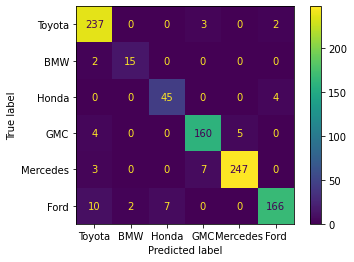

              precision    recall  f1-score   support

      Toyota       0.95      0.97      0.96       242
         BMW       0.89      0.94      0.91        17
       Honda       0.87      0.92      0.89        49
         GMC       0.94      0.95      0.94       169
    Mercedes       0.98      0.96      0.97       257
        Ford       0.95      0.91      0.93       185

   micro avg       0.95      0.95      0.95       919
   macro avg       0.93      0.94      0.93       919
weighted avg       0.95      0.95      0.95       919
 samples avg       0.94      0.95      0.95       919



C:\Users\Elyas Almubarak\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print('Active Learning RF(Entropy) Model Performance on Testing Set:')
evaluate_model(model,X_test,y_test)